In [1]:
import json
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import datetime
import plotly.graph_objects as go
import plotly.express as px
import plotly


plotly.offline.init_notebook_mode(connected=True)

lebanon_events_file = '../data/lebanon_conflicts.json'

with open(lebanon_events_file) as f:
    lebanon_conflicts_json = json.load(f)
    lebanon_war_events_json = lebanon_conflicts_json['JSON'][0]['settings']['leaflet'][0]['features']
    
lebanon_war_events = pd.DataFrame(lebanon_war_events_json).drop(['cssClass', 'icon', 'type', 'feature_id'], axis=1)

lebanon_war_events.head()

,lat,lon,popup
0,33.7545,35.6015,"<span class=""date-display-range""><span class=""..."
1,33.7373,35.5977,"<span class=""date-display-range""><span class=""..."
2,33.8338,35.6205,"<span class=""date-display-range""><span class=""..."
3,33.7413,35.6692,"<span class=""date-display-range""><span class=""..."
4,33.7933,35.5162,"<span class=""date-display-single"">July 1, 1978..."


In [2]:
lebanon_war_events['popup'][2]

'<span class="date-display-range"><span class="date-display-start">August 1, 1977</span> to <span class="date-display-end">December 31, 1977</span></span><br /><a href="/sir/christians-targeted-upper-metn-and-aley">Christians targeted in Upper Metn and Aley</a><br />Aabadiye'

In [3]:
def extract_date(row, start_or_end):
    assert start_or_end == 'start' or 'end', 'start_or_end should be either "start" or "end"'
    soup = BeautifulSoup(row['popup'])
    class_ = 'date-display-' + start_or_end
    try:
        date = soup.findAll('span', {'class': class_})[0]
    
    except IndexError:
        class_ = 'date-display-single'
        date = soup.findAll('span', {'class': class_})[0]
    
    date_time_obj = datetime.datetime.strptime(date.text, '%B %d, %Y')
    return date_time_obj


def extract_event(row):
    soup = BeautifulSoup(row['popup'])
    event = soup.findAll('a')[0]
    return event.text


def extract_location_name(row):
    return row['popup'].split('<br />')[2]
    
lebanon_war_events['start'] = lebanon_war_events.apply(lambda row: extract_date(row, 'start'), axis=1)
lebanon_war_events['end'] = lebanon_war_events.apply(lambda row: extract_date(row, 'end'), axis=1)
lebanon_war_events['event'] = lebanon_war_events.apply(extract_event, axis=1)
lebanon_war_events['location_name'] = lebanon_war_events.apply(extract_location_name, axis=1)

lebanon_war_events_final = lebanon_war_events.drop('popup', axis=1)

lebanon_war_events_final

,lat,lon,start,end,event,location_name
0,33.7545,35.6015,1977-08-01,1977-12-31,Christians targeted in Upper Metn and Aley,Rouisset en Naamane
1,33.7373,35.5977,1977-08-01,1977-12-31,Christians targeted in Upper Metn and Aley,Rechmaiya
2,33.8338,35.6205,1977-08-01,1977-12-31,Christians targeted in Upper Metn and Aley,Aabadiye
3,33.7413,35.6692,1977-08-01,1977-12-31,Christians targeted in Upper Metn and Aley,Mreijat
4,33.7933,35.5162,1978-07-01,1978-07-01,Christians executed near Aley,Deir Qoubil
...,...,...,...,...,...,...
689,33.8882,35.5009,1985-08-12,1985-08-12,Hundreds of mortar shells fired across East an...,Beirut
690,34.1204,35.6471,1985-08-21,1985-08-21,"Bombing continues, reaching 190 towns, village...",Jbail
691,34.1204,35.6471,1985-08-20,1985-08-20,"Heavy shelling over Beirut, Jbeil and Batroun....",Jbail
692,34.2563,35.6581,1985-08-20,1985-08-20,"Heavy shelling over Beirut, Jbeil and Batroun....",Batroun


In [4]:
def load_geoJson( file_in):
    
    with open(file_in) as file_in:
        districts = json.load(file_in)
    
    district_features = districts['features']
    
    return district_features

In [5]:
def create_geoDict (geoJson):
    
    geoJSON=dict(type= 'FeatureCollection', 
             features = [])
    
    for k, tfeature in enumerate(geoJson):
        geo_feature = dict(id=tfeature['properties']['DISTRICT'], type= "Feature")
        geo_feature['properties'] = tfeature['properties']
        geo_feature['geometry'] = tfeature['geometry']  
        geoJSON['features'].append(geo_feature)
        
    return geoJSON

In [6]:
file_in = '2009_districts.geojson'
districts_geo = load_geoJson(file_in)
districts_geo_dict = create_geoDict (districts_geo)

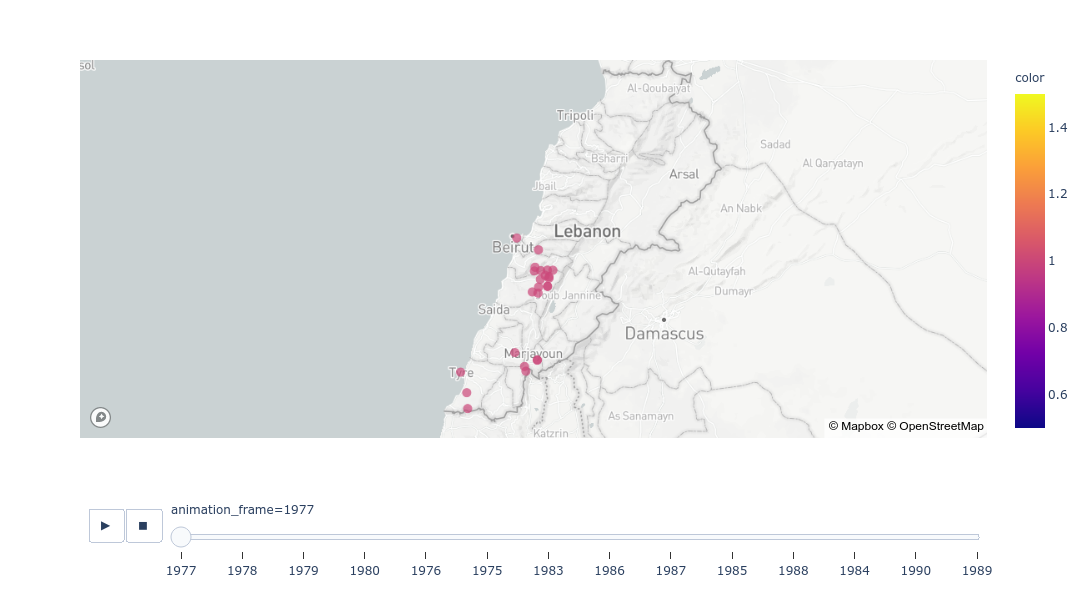

In [16]:
px.set_mapbox_access_token(open('.mapbox_token').read())

fig = px.scatter_mapbox(
    lebanon_war_events_final,
    lon='lon',
    lat='lat',
    hover_data=['event'],
    animation_frame=lebanon_war_events_final.apply(lambda row: row['start'].year, axis=1),
    size_max=15,
    zoom=7,
    color=[1] * lebanon_war_events_final.shape[0]
)

fig.update_traces(
    marker=go.scattermapbox.Marker(
        size=10,
        color='#e85a4f',
        opacity=0.7,
        showscale=False
    ),
)

fig.show()

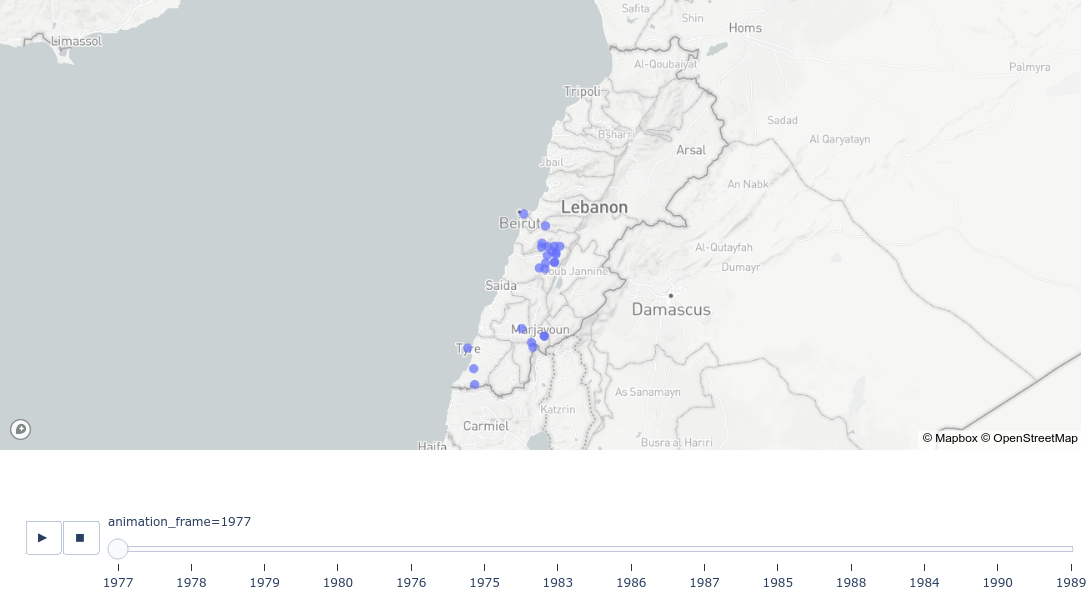

In [41]:
px.set_mapbox_access_token(open('.mapbox_token').read())

fig = px.scatter_mapbox(
    lebanon_war_events_final,
    lon='lon',
    lat='lat',
    hover_data=['event'],
    animation_frame=lebanon_war_events_final.apply(lambda row: row['start'].year, axis=1),
    size_max=15,
    zoom=7,
)


fig.update_traces(
    marker=go.scattermapbox.Marker(
        size=10,
        opacity=0.7,
        showscale=False
    ),
)

fig.update_layout(
    margin=dict(l=0, r=5, t=0, b=0),
)

fig.show()

In [44]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

plotly.offline.plot(fig, filename='../plots/war-events.html')

'../plots/war-events.html'